<a href="https://colab.research.google.com/github/zacharylazzara/tent-detection/blob/main/PyTorch_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Referenced Materials**

* https://amaarora.github.io/2020/09/13/unet.html
* https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
* https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
* https://www.youtube.com/watch?v=IHq1t7NxS8k

The majority of this comes from the referenced YouTube video

In [1]:
# Imports
!pip install segmentation-models-pytorch
!pip install -U albumentations

import os
import random
import torch
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm


from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
from google.colab.patches import cv2_imshow
from pathlib import Path
from glob import glob

     |████████████████████████████████| 87 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 4.9 MB/s 
     |████████████████████████████████| 376 kB 25.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=4a9e4165fc544f837425e271565c78928430b4ac1f0f95994cf9b276f184aa74
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=380c6dd71355d95f4cd8b3e5479ffd71fcef51ed7c4892695bd07edc56f4bb62
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 102 kB 5.4 MB/s 
     |████████████████████████████████| 37.1 MB 46 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
   

In [2]:
# Initialize Environment
%env SRC_DIR       = sarpol-zahab-tents
%env DATA_DIR      = data/
%env TRAIN_IMG_DIR = data/train_images/
%env TRAIN_LBL_DIR = data/train_labels/
%env VAL_IMG_DIR   = data/val_images/
%env VAL_LBL_DIR   = data/val_labels/
%env PREDICT_DIR   = predictions/

env: SRC_DIR=sarpol-zahab-tents
env: DATA_DIR=data/
env: TRAIN_IMG_DIR=data/train_images/
env: TRAIN_LBL_DIR=data/train_labels/
env: VAL_IMG_DIR=data/val_images/
env: VAL_LBL_DIR=data/val_labels/
env: PREDICT_DIR=predictions/


In [3]:
# Configuration
# Display Limit
DISP_LIMIT    = 1 # Maximum number of images to display
DISP_RESULTS  = True
DISP_SCALE    = 5 # Amount to divide displayed figure scale by

# Directories
SRC_DIR       = os.environ.get("SRC_DIR")
DATA_DIR      = os.environ.get("DATA_DIR")
TRAIN_IMG_DIR = os.environ.get("TRAIN_IMG_DIR")
TRAIN_LBL_DIR = os.environ.get("TRAIN_LBL_DIR")
VAL_IMG_DIR   = os.environ.get("VAL_IMG_DIR")
VAL_LBL_DIR   = os.environ.get("VAL_LBL_DIR")
PREDICT_DIR   = os.environ.get("PREDICT_DIR")

# Images
IMG_FORMAT    = "png"

# Checkpoints
CHECKPOINT    = "checkpoint.pth.tar"

# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE    = 1#5 # Batch size defines the prediction batch; set to 1 if we want individual files
NUM_EPOCHS    = 50 #100
NUM_WORKERS   = 2
IMAGE_HEIGHT  = 512//4
IMAGE_WIDTH   = 512//4
PIN_MEMORY    = True
LOAD_MODEL    = False

# Convolution Settings
C_KERNEL      = 3     # This is the matrix that slides across the image (we define matrix size, so kernel = 3 means 3x3 matrix that slides across the image)
C_STRIDE      = 1     # Number of pixels the kernel slides over the input (how many pixels we move the filter at a time)
C_PADDING     = 1     # Sometimes the filter doesn't perfectly fit the input image, in which case we can pad with 0s or drop the part of the image that didn't fit (called valid padding)
C_BIAS        = False # Bias is false in this case because we're using BatchNorm2d (bias would be canceled by the batch norm, so we set it to false)
R_INPLACE     = True  #

# UNet Settings
IN_CHANNELS   = 3
OUT_CHANNELS  = 1 # We're doing binary image segmentation (because our masks are black and white), so we can output a single channel
U_FEATURES    = [64, 128, 256, 512] # Features come from the architecture (the number above the boxes)

# UNet Pool Settings
P_KERNEL      = 2
P_STRIDE      = 2

# Final layer kernel size
F_KERNEL      = 1 # Because we're outputting the final image here

In [4]:
# Initialize Directories
%%bash
echo "Working in Directory: $(pwd)"

if [ -d 'sample_data' ]; then
  rm -r sample_data
fi

if [ ! -d $SRC_DIR ]; then
 git clone https://github.com/tofighi/sarpol-zahab-tents.git
fi

if [ ! -d $TRAIN_IMG_DIR ]; then
  mkdir -p $TRAIN_IMG_DIR
fi

if [ ! -d $TRAIN_LBL_DIR ]; then
  mkdir -p $TRAIN_LBL_DIR
fi

if [ ! -d $VAL_IMG_DIR ]; then
  mkdir -p $VAL_IMG_DIR
fi

if [ ! -d $VAL_LBL_DIR ]; then
  mkdir -p $VAL_LBL_DIR
fi

if [ ! -d $PREDICT_DIR ]; then
  mkdir -p $PREDICT_DIR
fi

Working in Directory: /content


Cloning into 'sarpol-zahab-tents'...


In [5]:
# Print Device
print("Device: ", DEVICE)

Device:  cuda


In [6]:
# Preparing Data
def load(path):
  return np.array([np.asarray(Image.open(path)) for path in sorted(glob(path))])

src_imgs = load("{}/data/images/*".format(SRC_DIR))
src_lbls = load("{}/data/labels/*".format(SRC_DIR))

dataset = []
# Dataset Structure:
# [
#   0:{
#     img:  image
#     lbl:  label
#     filename: {img: 0.png, lbl: 0.png}
#   },
#   1:{}, 2:{}, n:{}
# ]

if src_imgs.shape[0] == src_lbls.shape[0]:
  n = src_lbls.shape[0]

  for index in range(n):
    dataset.append({
      "img":Image.fromarray(src_imgs[index]),
      "lbl":Image.fromarray(src_lbls[index]),
      "filename":{
        "img":f"{index}.{IMG_FORMAT}",
        "lbl":f"{index}.{IMG_FORMAT}"
      }
    })

def save_data(data, val=False):
  img_dir = TRAIN_IMG_DIR
  lbl_dir = TRAIN_LBL_DIR

  if val:
    img_dir = VAL_IMG_DIR
    lbl_dir = VAL_LBL_DIR

  data["img"].save(f"{img_dir}/{data['filename']['img']}")
  data["lbl"].save(f"{lbl_dir}/{data['filename']['lbl']}")

for data in dataset:
  
  # We're throwing out images that don't contain tents (for now; need to change this later)
  if np.asarray(data["lbl"]).sum() > 0:
    save_data(data, val=bool(random.getrandbits(1))) # TODO: will need a way to skew the results of random so we can distribute by percentages

In [7]:
# Cleanup
%%bash
if [ -d $SRC_DIR ]; then
  rm -r $SRC_DIR
fi

**U-Net Architecture:**

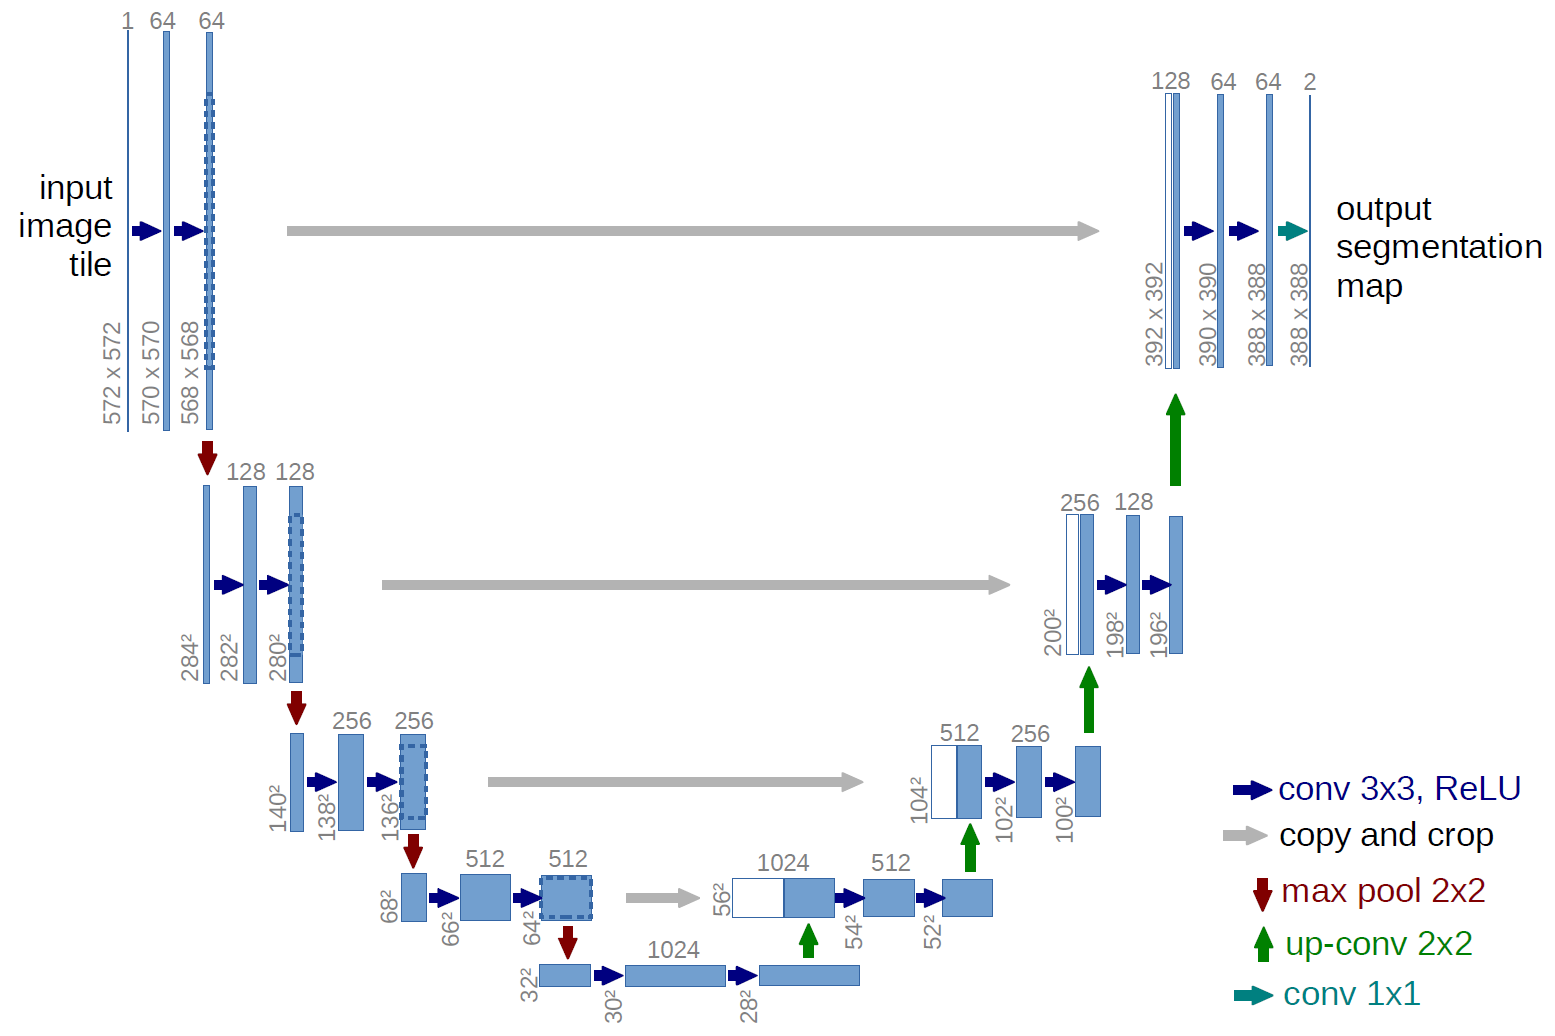

The first half of the architecture is the down-sampling process. At each stage, two 3x3 convolutions are used. The output is then pooled and becomes the input for the next 3x3 convolution and so on, until the bottom of this diagram is reached.

The second half of the architecture is the up-sampling process, which is a reflection of the down-sampling process.

In [8]:
# model.py


# # Referenced https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148
# # Convolution Settings
# C_KERNEL  = 3     # This is the matrix that slides across the image (we define matrix size, so kernel = 3 means 3x3 matrix that slides across the image)
# C_STRIDE  = 1     # Number of pixels the kernel slides over the input (how many pixels we move the filter at a time)
# C_PADDING = 1     # Sometimes the filter doesn't perfectly fit the input image, in which case we can pad with 0s or drop the part of the image that didn't fit (called valid padding)
# C_BIAS    = False # Bias is false in this case because we're using BatchNorm2d (bias would be canceled by the batch norm, so we set it to false)
# R_INPLACE = True  #

# # UNet Settings
# IN_CHANNELS  = 3
# OUT_CHANNELS = 1 # We're doing binary image segmentation (because our masks are black and white), so we can output a single channel
# U_FEATURES     = [64, 128, 256, 512] # Features come from the architecture (the number above the boxes)

# # UNet Pool Settings
# P_KERNEL = 2
# P_STRIDE = 2

# # Final layer kernel size
# F_KERNEL = 1 # Because we're outputting the final image here


# from https://www.youtube.com/watch?v=IHq1t7NxS8k
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential (
        nn.Conv2d(in_channels, out_channels, C_KERNEL, C_STRIDE, C_PADDING, bias=C_BIAS), # This is a same convolution (input height*width = output height*width)
        nn.BatchNorm2d(out_channels), # BatchNorm accelerates training by normalizing inputs by re-centering and re-scaling
        nn.ReLU(inplace=R_INPLACE), # ReLU is Rectified Linear Unit; essentially it makes it so negative inputs are discarded and positive inputs are passed through

        # Now we do this a second time but with out_channels to out_channels
        nn.Conv2d(out_channels, out_channels, C_KERNEL, C_STRIDE, C_PADDING, bias=C_BIAS),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=R_INPLACE),
    )

  def forward(self, x):
    return self.conv(x)

# DoubleConv is everything in the first node of the architecture (before pooling)

class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=U_FEATURES):
    super(UNet, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList() # Stores the convolutional layers; it's a list, but using ModuleList lets us use BatchNorm2d
    self.pool = nn.MaxPool2d(kernel_size=P_KERNEL, stride=P_STRIDE) # Pooling layer will be used inbetween, in forwarding method
    # Note that the pooling layer will require out inputs to be perfectly divisible by 2 because we're doing a stride of 2
    # Example: 161 x 161 -> MaxPool -> 80 x 80 -> Upsample -> 160 x 160; in this case, we couldn't concatinate the two as they need the same width and height for concat (161x161 is input, 160x160 is output)
    # If input is perfectly dividible by 16 then this issue won't happen (16 because its 4 steps, all dividing by 2 (16/(4*2) = 2))
    # In order to keep the system general, we can either pad the image or crop the image so that it works even if image size isn't perfectly divisible by 16


    # Down-Sampling part of UNet
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature)) # Mapping some input (in the UNet architecture example, it maps 1 to 64 for the first node)
      in_channels = feature

    # Up-Sampling Part of UNet
    # At 10:20 or so in the video he mentions transposed convoltions that may be a better method to this part, but we'll use similar approach to UNet paper for now
    # We're using the reversed list of features because we're going from the bottom up now
    for feature in reversed(features):
      
      # In_channels is feature*2 here, output is feature
      self.ups.append(
          nn.ConvTranspose2d( 
              feature*2, feature, kernel_size=P_KERNEL, stride=P_STRIDE
          )
      )
      self.ups.append(DoubleConv(feature*2, feature)) # Because we go up then do two convs then go up then do two convs etc

    # Bottom Layer
    self.bottleneck = DoubleConv(features[-1], features[-1]*2) # We're using features[-1] because we want the bottom feature

    # Now we do 1x1 conv which doesn't change height or width just number of channels
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=F_KERNEL)
  

  def forward(self, x):
    skip_connections = [] # We skip connections for each stage in the architecture, as we use this part later on
    
    # This loop does all the down-sampling steps until the final step just before the bottom layer (aka bottleneck)
    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1] # we wanna go backwards in order when we're doing our concatination; the highest resolution image is the first one; to make things easier, we'll just reverse this list

    # We're using a step of 2 here because we're going up then double conv each iteration
    for i in range(0, len(self.ups), 2):
      x = self.ups[i](x) # doing ConvTranspose2d here
      skip_connection = skip_connections[i//2] # // is integer division; we're doing a step of one ordering here

      # Dealing with images that are not perfectly dividible
      # TODO: perhaps we should look into scaling instead of cropping or padding, or perhaps we should scale before we put the image into the system, so that this is not relevant?
      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connections.shape[2:]) # we're taking out height and width here; basically, we're resizing the image if it doesn't fit

      concat_skip = torch.cat((skip_connection, x), dim=1) # dim 1 is the channel dimension; we're concationating these things along the channel dimension
      x = self.ups[i+1](concat_skip) # running it through a double conv
    
    return self.final_conv(x)




# Testing the implementation thus far
def test():
  x = torch.randn((3, 1, 160, 160))
  model = UNet(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

if __name__ == "__main__":
   test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [9]:
# TentDataset

# IMG_FORMAT       = 'png'
# IMG_TYPE         = 'RGB'
# IMG_SIZE         = 512

# SRC_DIR          = environ.get("SRC_DIR")
# DATA_DIR         = Path(f'data/dataset/')
# TRAIN_IMG_DIR    = DATA_DIR/'train'
# TRAIN_LBL_DIR    = DATA_DIR/'mask'



# Now we'll set up data loading part
# Starts around 22:30 in the video https://www.youtube.com/watch?v=IHq1t7NxS8k

# Data directory should be in the format:
# data
#   train_images
#   train_masks
#   val_images
#   val_masks

# Samples should be divided up between these directories (though we may be able to just use a dictionary for this instead so we can have easier control)


# TODO: might want to change how we handle the image and mask directories
class TentDataset(Dataset):
  def __init__(self, image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_LBL_DIR, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) # We use L since mask is grey scale
    mask[mask == 255.0] = 1.0 # Preprocessing; we change this cuz we're using a sigmoid on the last activation for probability of white pixel, so this makes it work better?

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [10]:
# Utils

def save_checkpoint(state, filename=CHECKPOINT):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(train_dir, train_maskdir, val_dir, val_maskdir, batch_size, train_transform, val_transform, num_workers=4, pin_memory=True):
  train_ds = TentDataset(image_dir=train_dir, mask_dir=train_maskdir, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)
  val_ds = TentDataset(image_dir=val_dir, mask_dir=val_maskdir, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
  return train_loader, val_loader

# if we'd have more classes this check accuracy would need to change
def check_accuracy(loader, model, device=DEVICE):
  num_correct = 0
  num_pixels = 0

  # Worst metric
  pixel_accuracy = 0
  
  # Better metrics
  dice_score = 0
  similarity = 0 # Gives us worst case score

  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1) # label doesn't have a channel cuz its' greyscale so we have to do this so accuracy works properly
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)

      # For both of these metrics we add 1e-8 to the denominator to avoid possible division by 0 (1e-8 is a very small number that won't impact the results much).
      # These metrics should have a score between 0 and 1.

      # Jaccard Similarity Coefficient (aka Jaccard Index)
      similarity += (preds * y).sum() / ((preds + y).sum() + 1e-8)

      # Dice Score (aka F1-Score)
      dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

  pixel_accuracy = num_correct/num_pixels
  
  # NOTE: The pixel accuracy should be ignored, as it does not accurately represent the results
  print(f"Pixel Accuracy: {num_correct}/{num_pixels} = {pixel_accuracy*100:.2f}%")

  # Dividing dice score and Jaccard index because they are being summed for each value in the loader, thus are averages
  print(f"Average Dice Score: {dice_score/len(loader)}")
  print(f"Average Similarity: {similarity/len(loader)}")

  model.train()

# def save_predictions_as_imgs(loader, model, folder=PREDICT_DIR, device=DEVICE):
#   model.eval()
#   for idx, (x, y) in enumerate(loader):
#     x = x.to(device=device)
#     with torch.no_grad():
#       preds = torch.sigmoid(model(x))
#       preds = (preds > 0.5).float()
#     torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.{IMG_FORMAT}")
#     torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.{IMG_FORMAT}")
  
#   model.train()




# TODO: we need predictions to save as individual files per prediction not concatinated like they seem to be
def save_predictions_as_imgs(loader, model, folder=PREDICT_DIR, device=DEVICE):
  model.eval()
  for idx, (x, y) in enumerate(loader):
    x = x.to(device=device)
    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
    torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.{IMG_FORMAT}")
    torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.{IMG_FORMAT}")
  
  model.train()

Pixel Accuracy: 6378/770048 = 0.83%
Average Dice Score: 0.5603413581848145
Average Similarity: 0.2801706790924072


100%|██████████| 43/43 [00:05<00:00,  8.36it/s, loss=-.588]


=> Saving checkpoint
Pixel Accuracy: 504601/770048 = 65.53%
Average Dice Score: 0.8919534683227539
Average Similarity: 0.44597673416137695
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


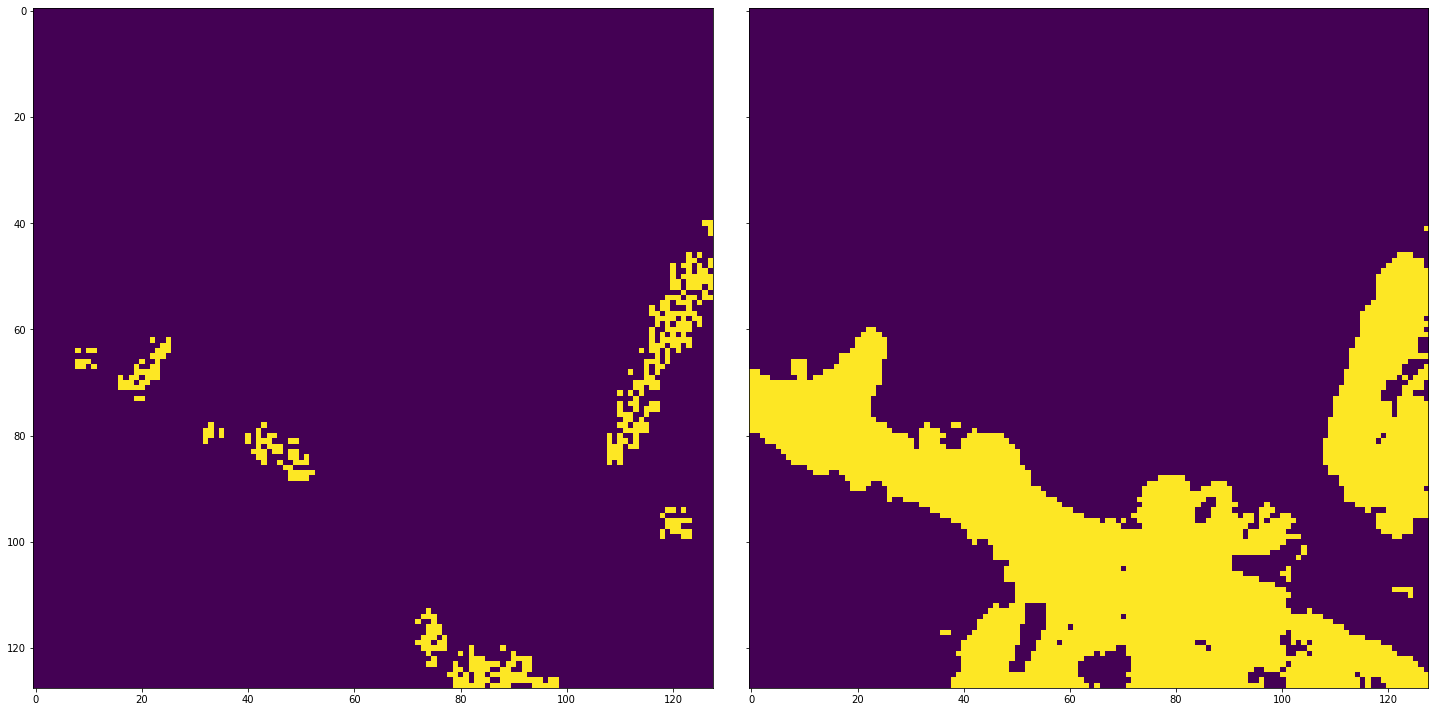

100%|██████████| 43/43 [00:05<00:00,  8.30it/s, loss=-.0805]


=> Saving checkpoint
Pixel Accuracy: 314829/770048 = 40.88%
Average Dice Score: 0.7105540037155151
Average Similarity: 0.35527700185775757
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


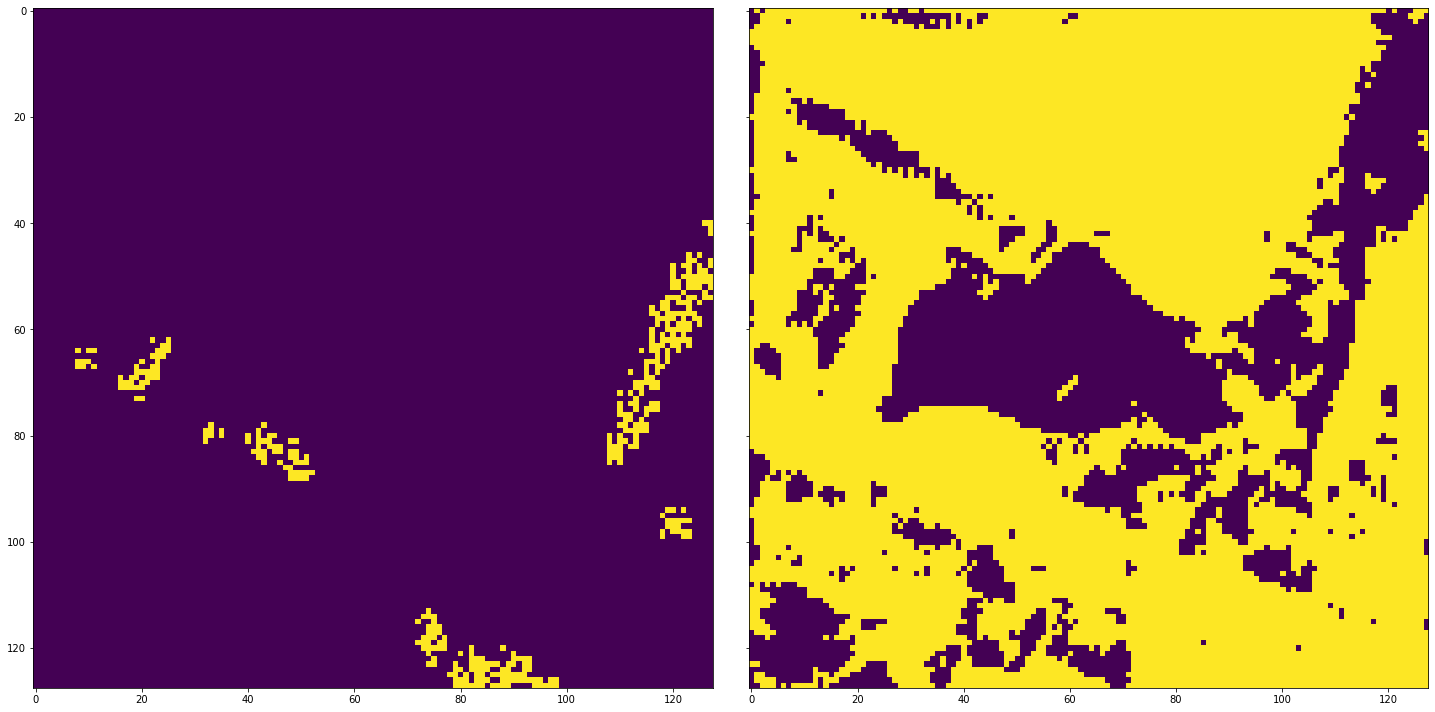

100%|██████████| 43/43 [00:05<00:00,  8.34it/s, loss=1.03]


=> Saving checkpoint
Pixel Accuracy: 635107/770048 = 82.48%
Average Dice Score: 1.1841968297958374
Average Similarity: 0.5920984148979187
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


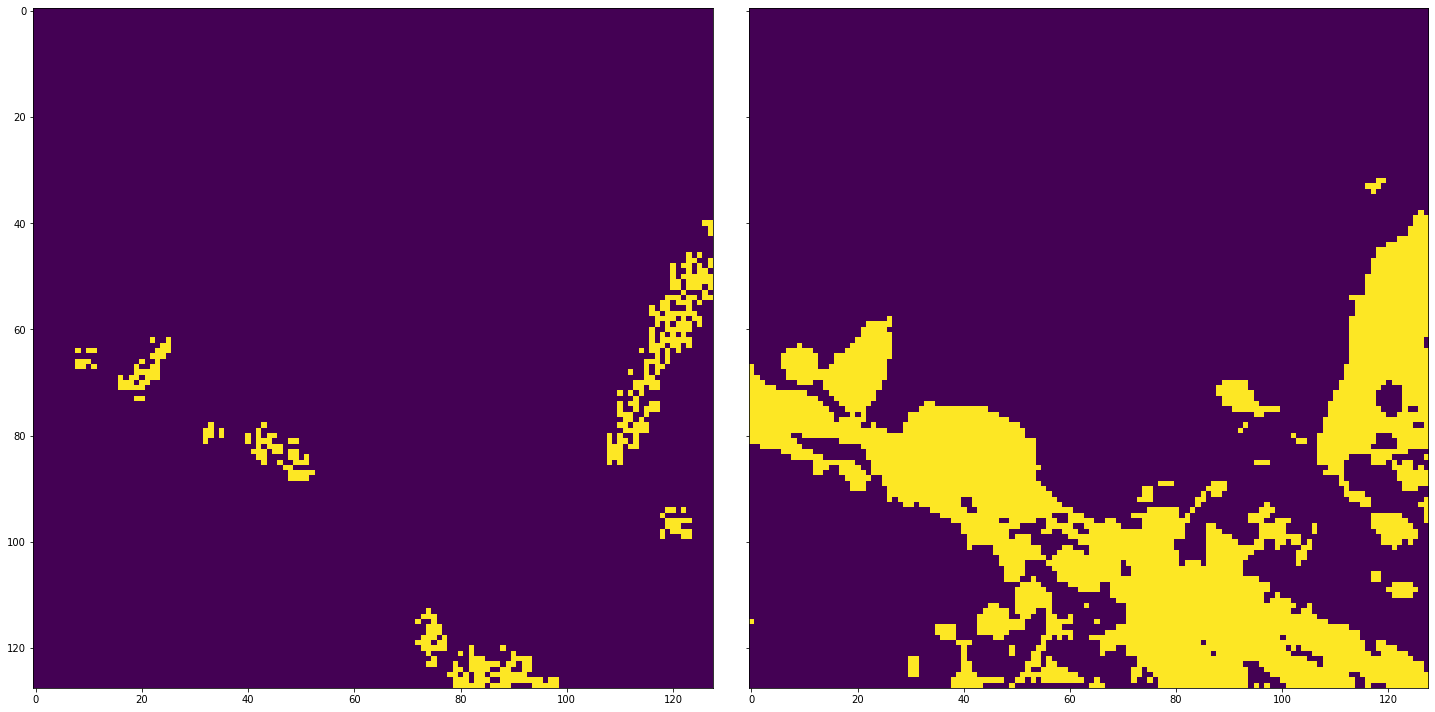

100%|██████████| 43/43 [00:05<00:00,  8.21it/s, loss=0.662]


=> Saving checkpoint
Pixel Accuracy: 463047/770048 = 60.13%
Average Dice Score: 0.8909381628036499
Average Similarity: 0.44546908140182495
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


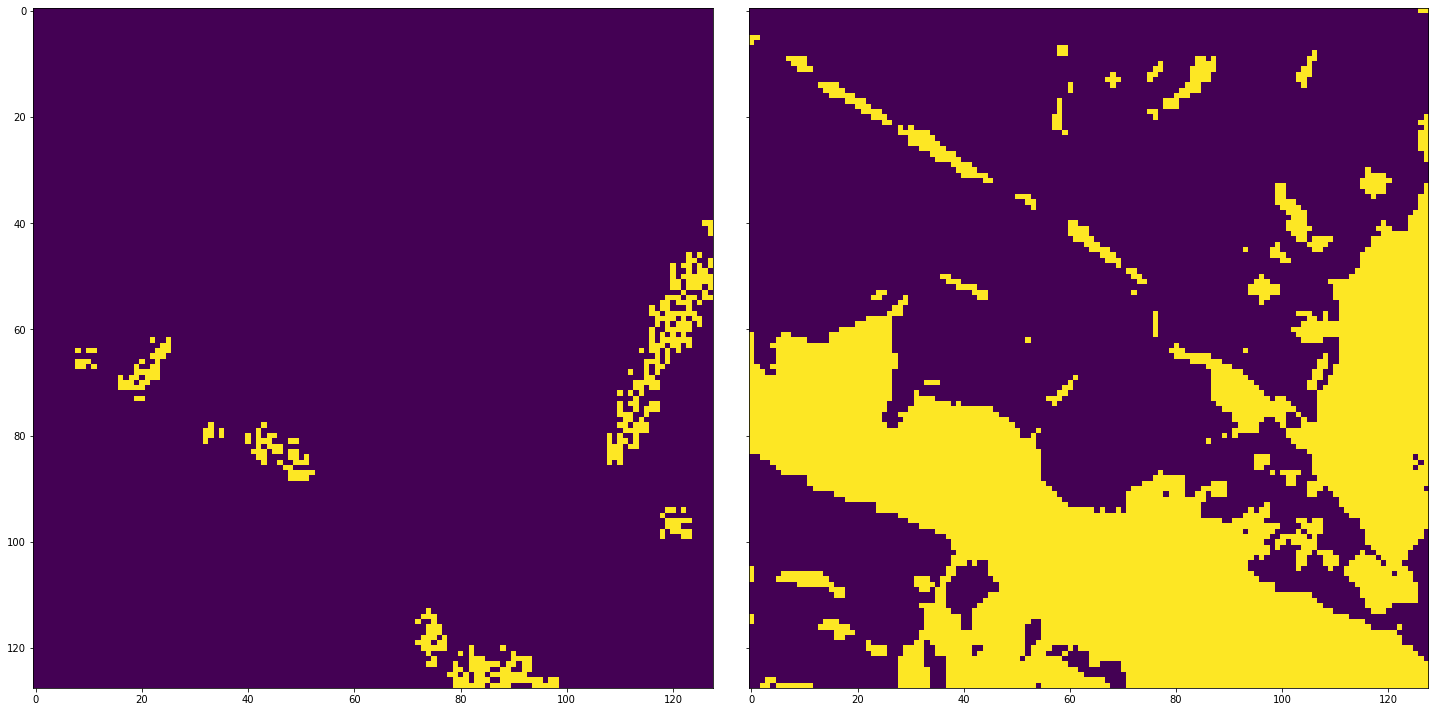

100%|██████████| 43/43 [00:05<00:00,  8.31it/s, loss=0.346]


=> Saving checkpoint
Pixel Accuracy: 376905/770048 = 48.95%
Average Dice Score: 0.7731992602348328
Average Similarity: 0.3865996301174164
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


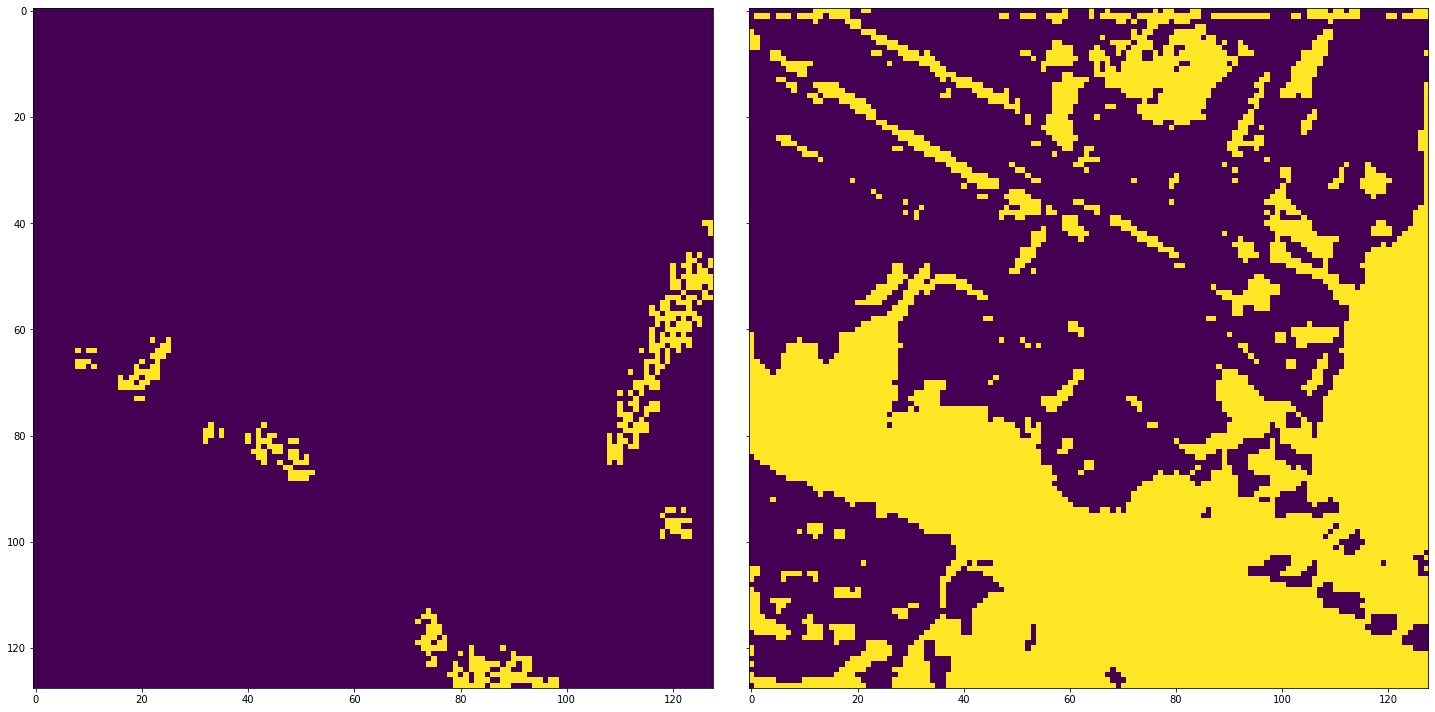

100%|██████████| 43/43 [00:05<00:00,  8.23it/s, loss=1.02]


=> Saving checkpoint
Pixel Accuracy: 411969/770048 = 53.50%
Average Dice Score: 0.7897217869758606
Average Similarity: 0.3948608934879303
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


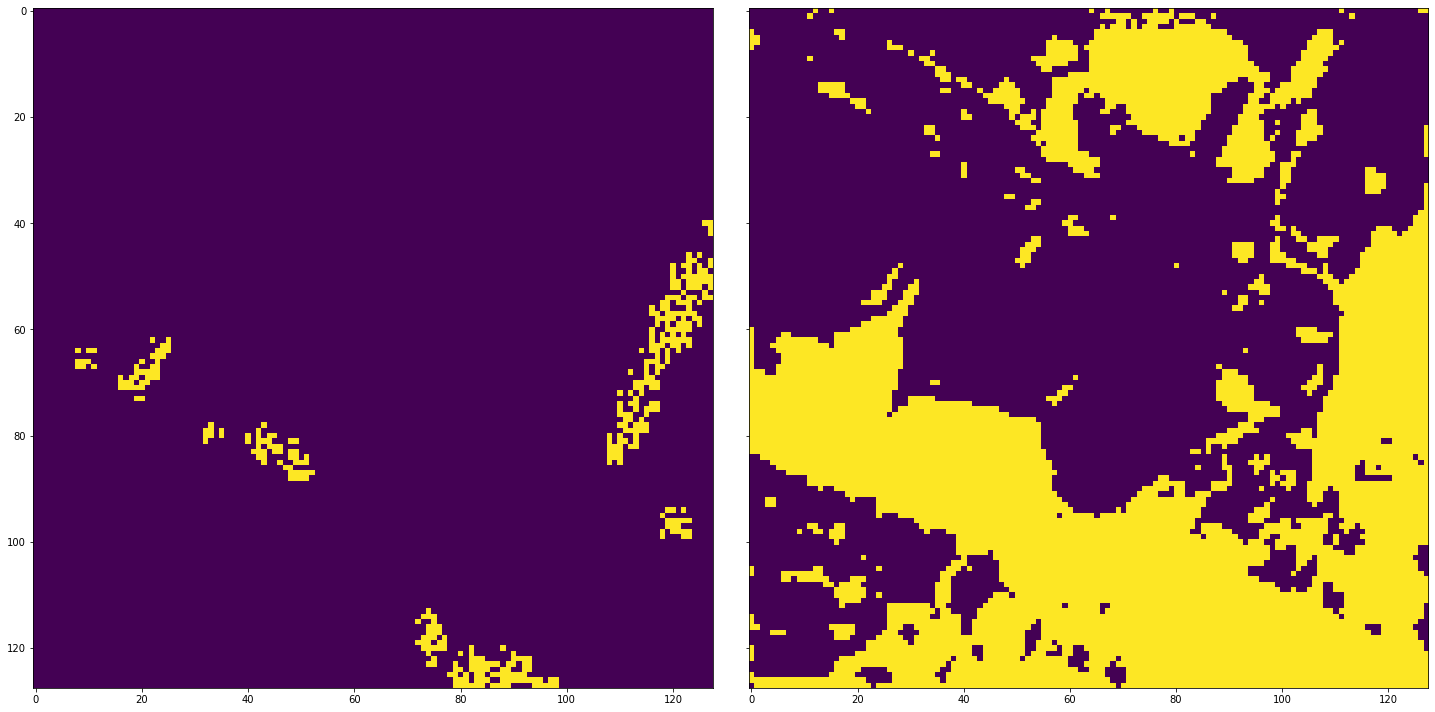

100%|██████████| 43/43 [00:05<00:00,  8.31it/s, loss=-3.45]


=> Saving checkpoint
Pixel Accuracy: 473745/770048 = 61.52%
Average Dice Score: 0.8645525574684143
Average Similarity: 0.43227627873420715
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


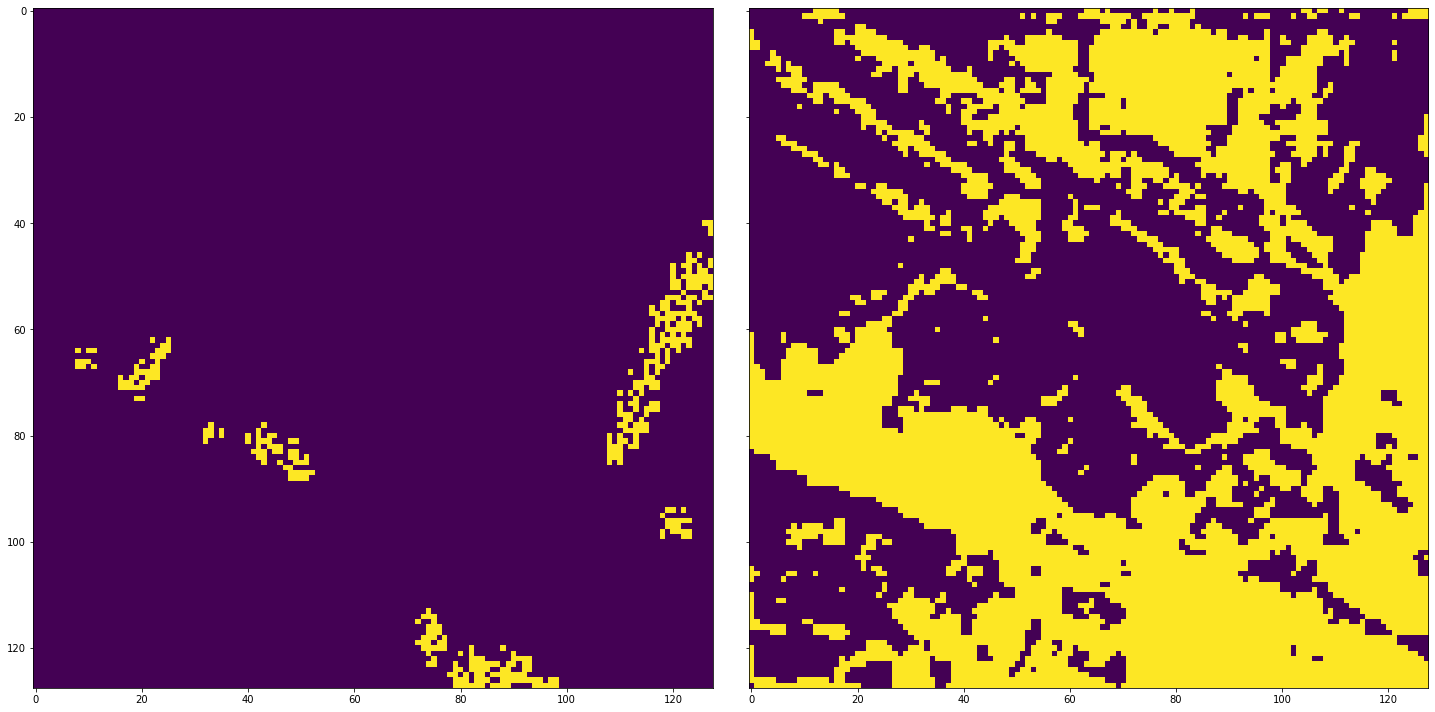

100%|██████████| 43/43 [00:05<00:00,  8.25it/s, loss=-15.2]


=> Saving checkpoint
Pixel Accuracy: 635141/770048 = 82.48%
Average Dice Score: 1.0738431215286255
Average Similarity: 0.5369215607643127
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


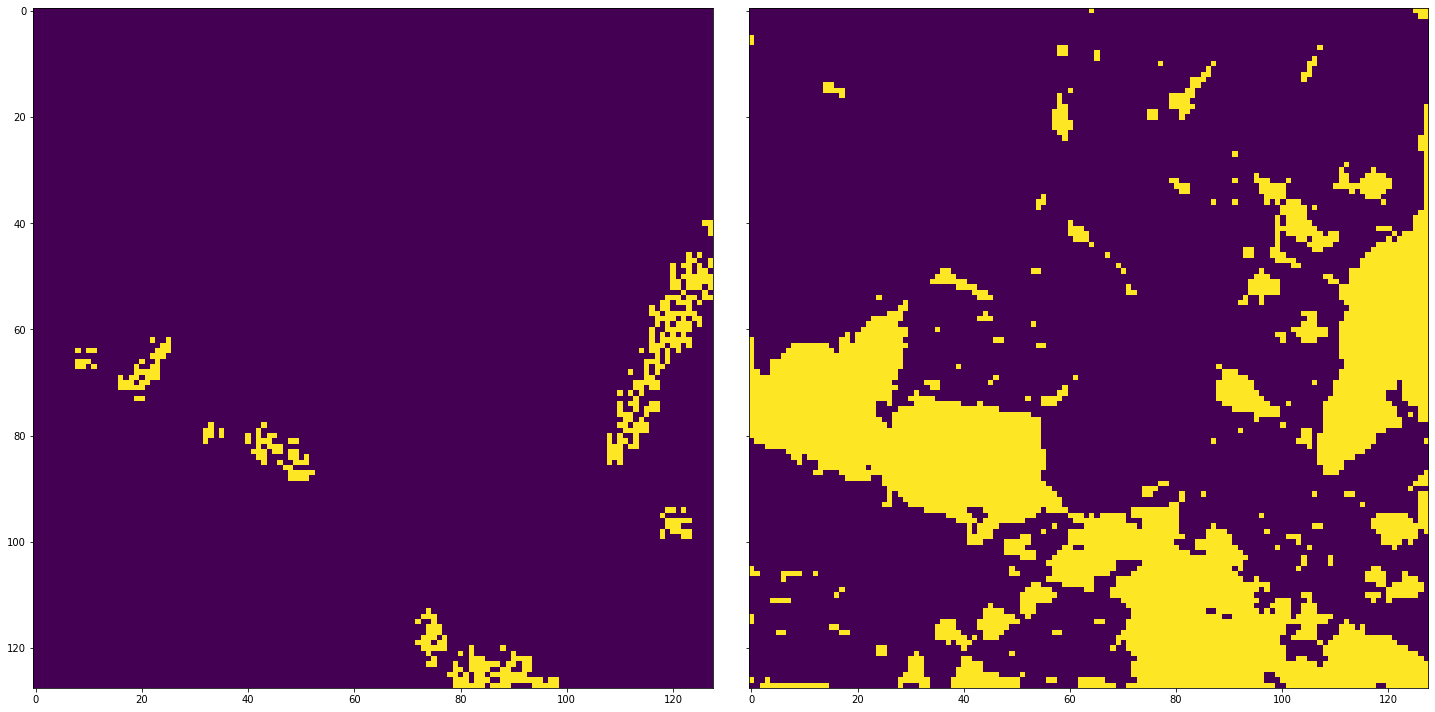

100%|██████████| 43/43 [00:05<00:00,  8.23it/s, loss=-10.9]


=> Saving checkpoint
Pixel Accuracy: 353038/770048 = 45.85%
Average Dice Score: 0.7755771279335022
Average Similarity: 0.3877885639667511
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


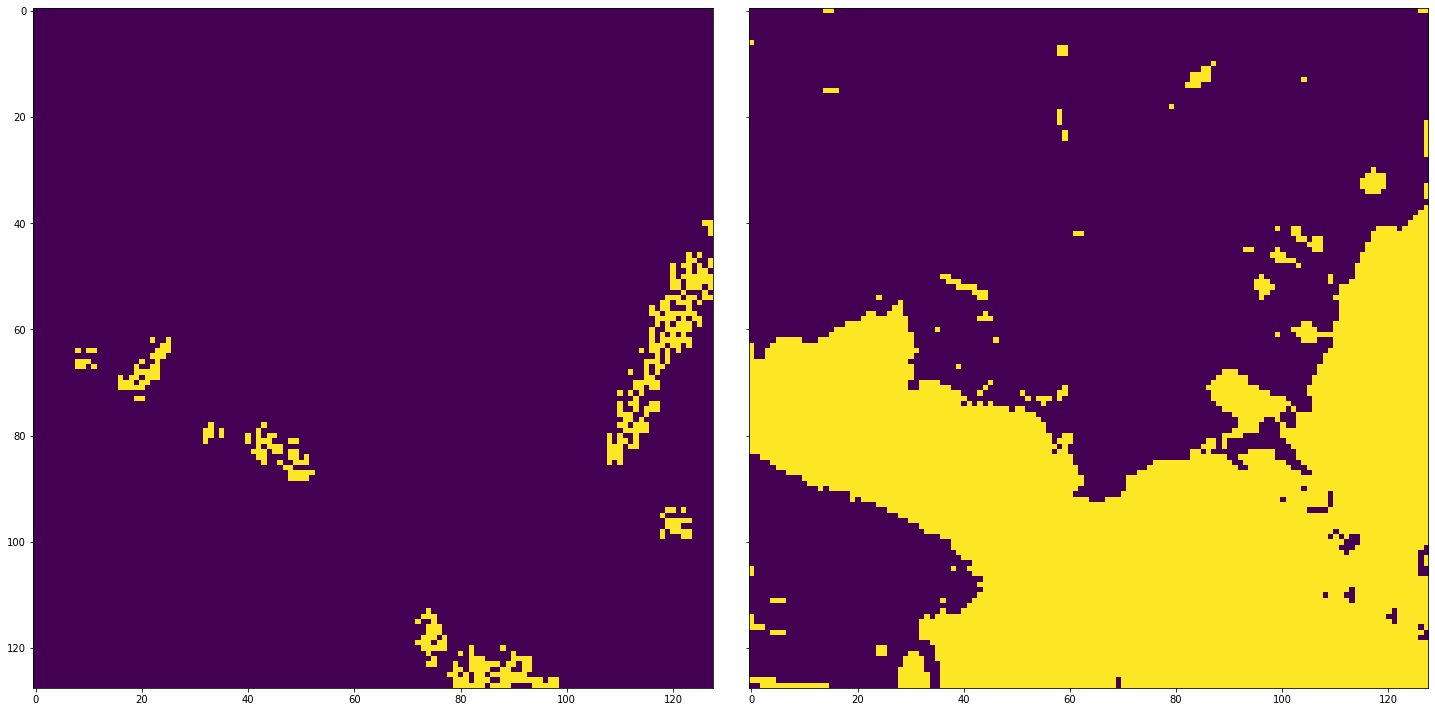

100%|██████████| 43/43 [00:05<00:00,  8.17it/s, loss=-12.4]


=> Saving checkpoint
Pixel Accuracy: 658894/770048 = 85.57%
Average Dice Score: 1.1212934255599976
Average Similarity: 0.5606467127799988
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


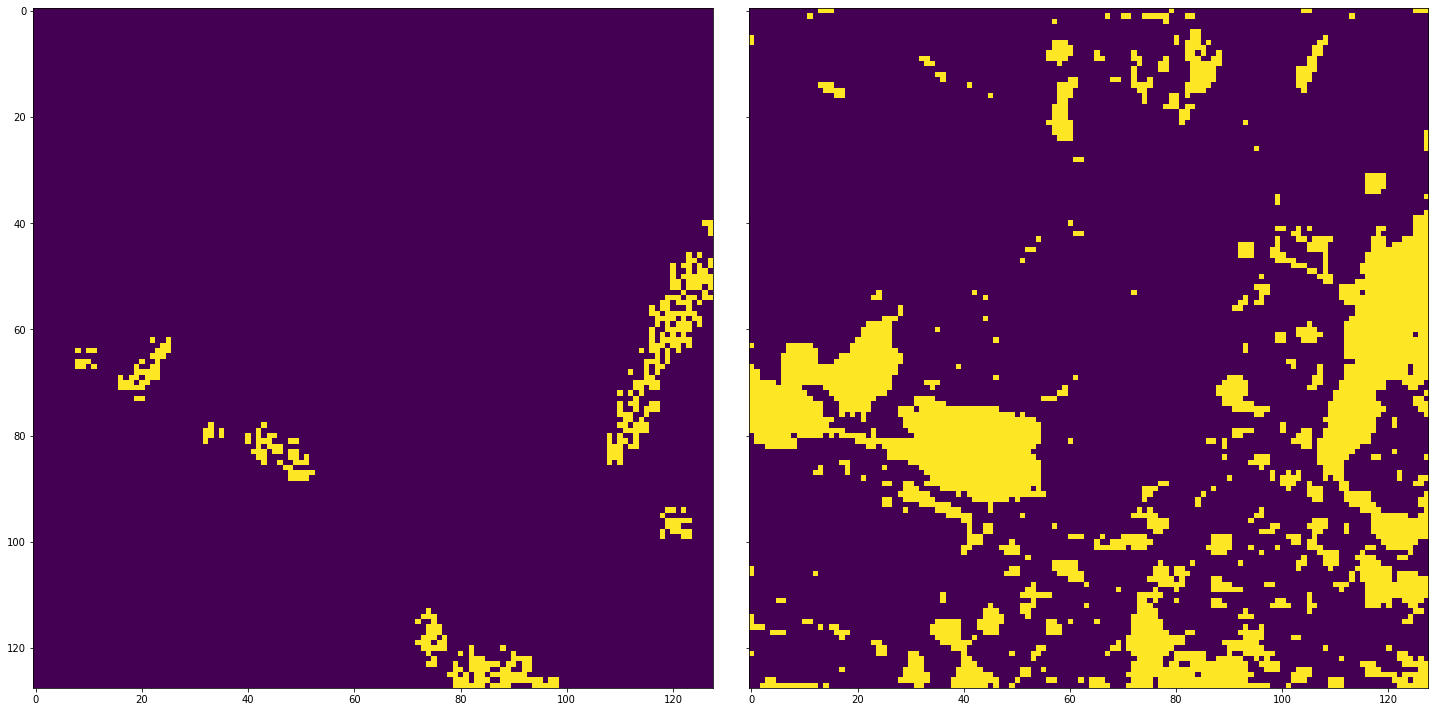

100%|██████████| 43/43 [00:05<00:00,  8.34it/s, loss=-7.01]


=> Saving checkpoint
Pixel Accuracy: 541767/770048 = 70.35%
Average Dice Score: 0.9963142275810242
Average Similarity: 0.4981571137905121
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


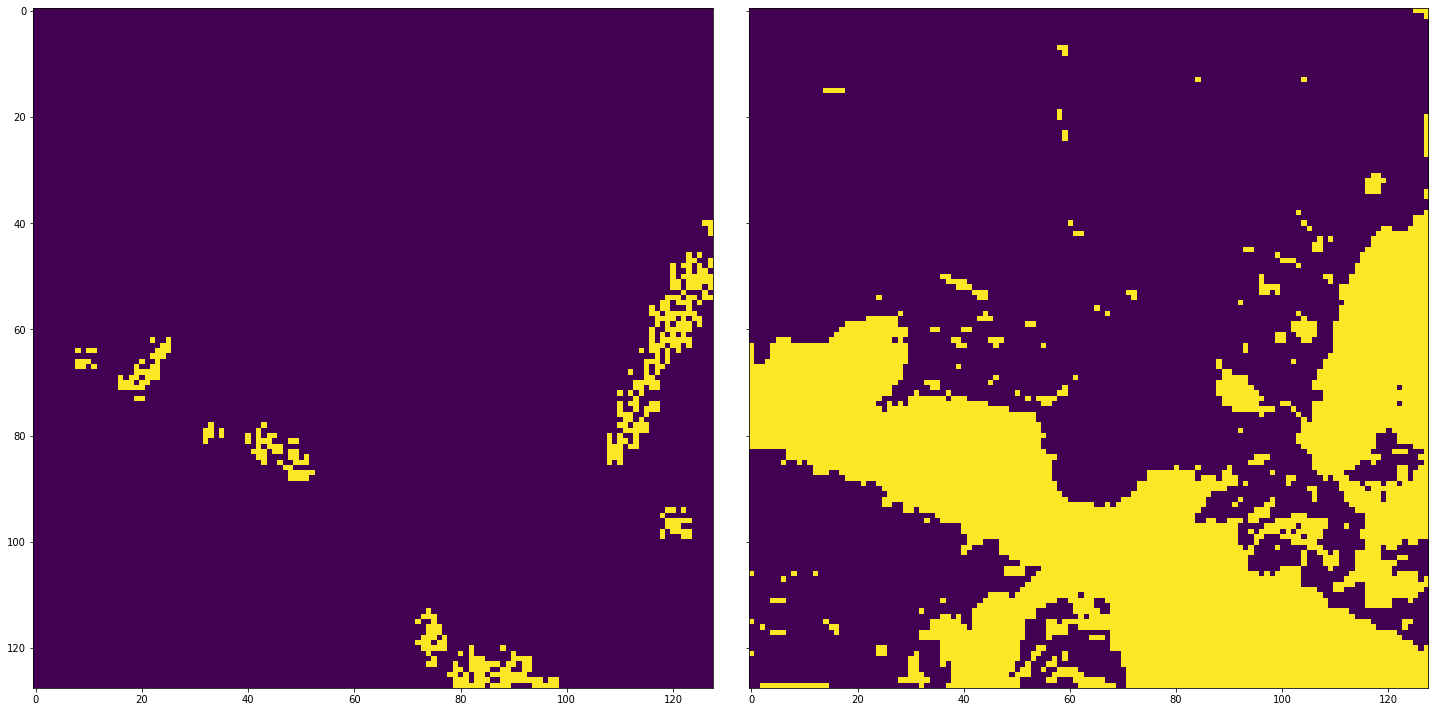

100%|██████████| 43/43 [00:05<00:00,  8.23it/s, loss=-23.9]


=> Saving checkpoint
Pixel Accuracy: 482928/770048 = 62.71%
Average Dice Score: 0.931629478931427
Average Similarity: 0.4658147394657135
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


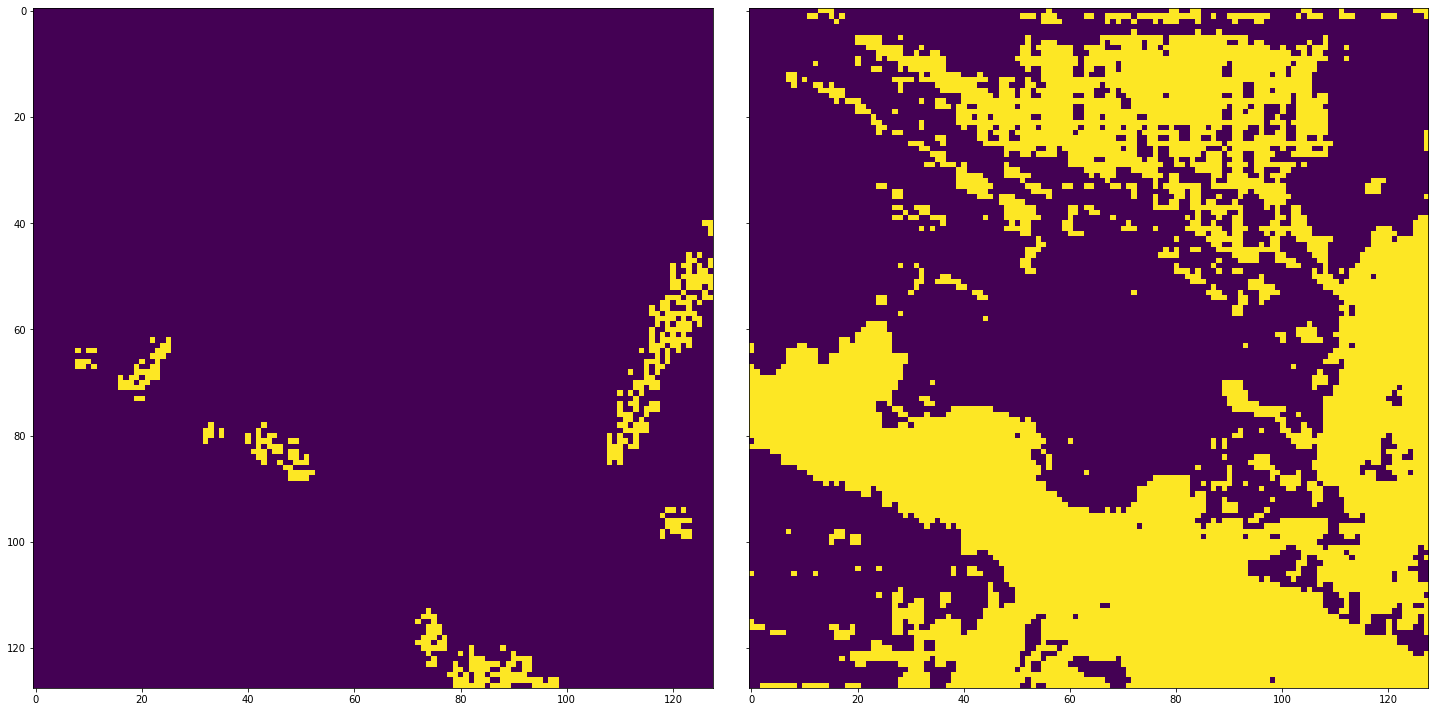

100%|██████████| 43/43 [00:05<00:00,  8.28it/s, loss=-9.24]


=> Saving checkpoint
Pixel Accuracy: 652128/770048 = 84.69%
Average Dice Score: 1.1319745779037476
Average Similarity: 0.5659872889518738
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


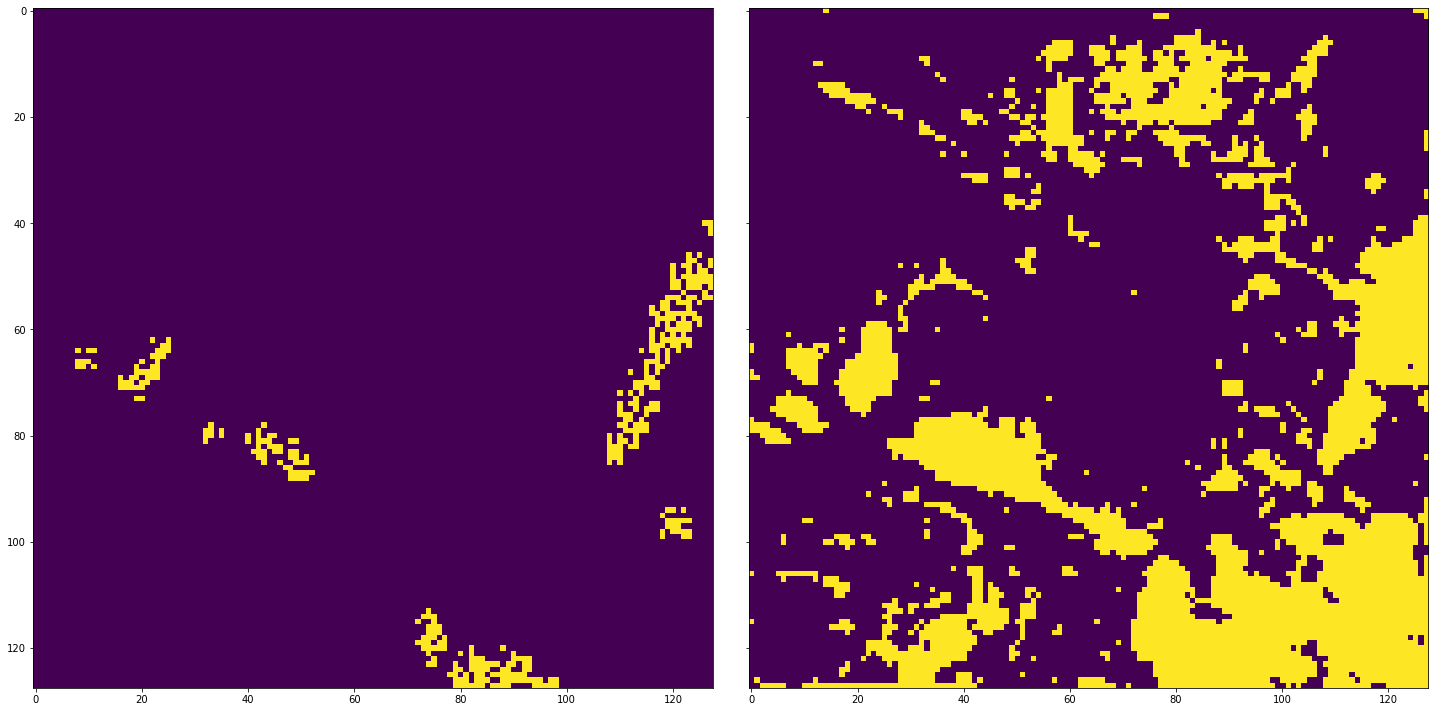

100%|██████████| 43/43 [00:05<00:00,  8.24it/s, loss=-20]


=> Saving checkpoint
Pixel Accuracy: 604321/770048 = 78.48%
Average Dice Score: 0.9578380584716797
Average Similarity: 0.47891902923583984
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


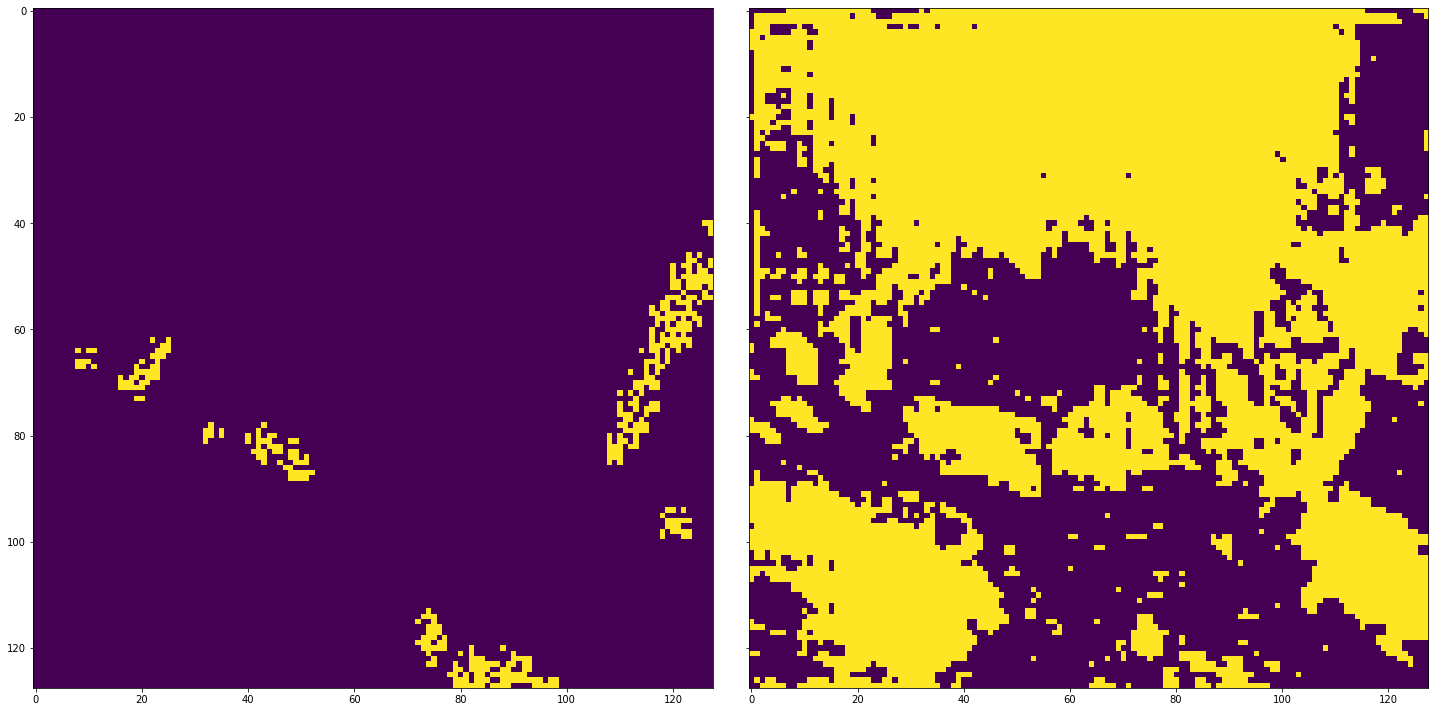

100%|██████████| 43/43 [00:05<00:00,  8.22it/s, loss=-7.54]


=> Saving checkpoint
Pixel Accuracy: 507539/770048 = 65.91%
Average Dice Score: 0.9982559084892273
Average Similarity: 0.49912795424461365
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


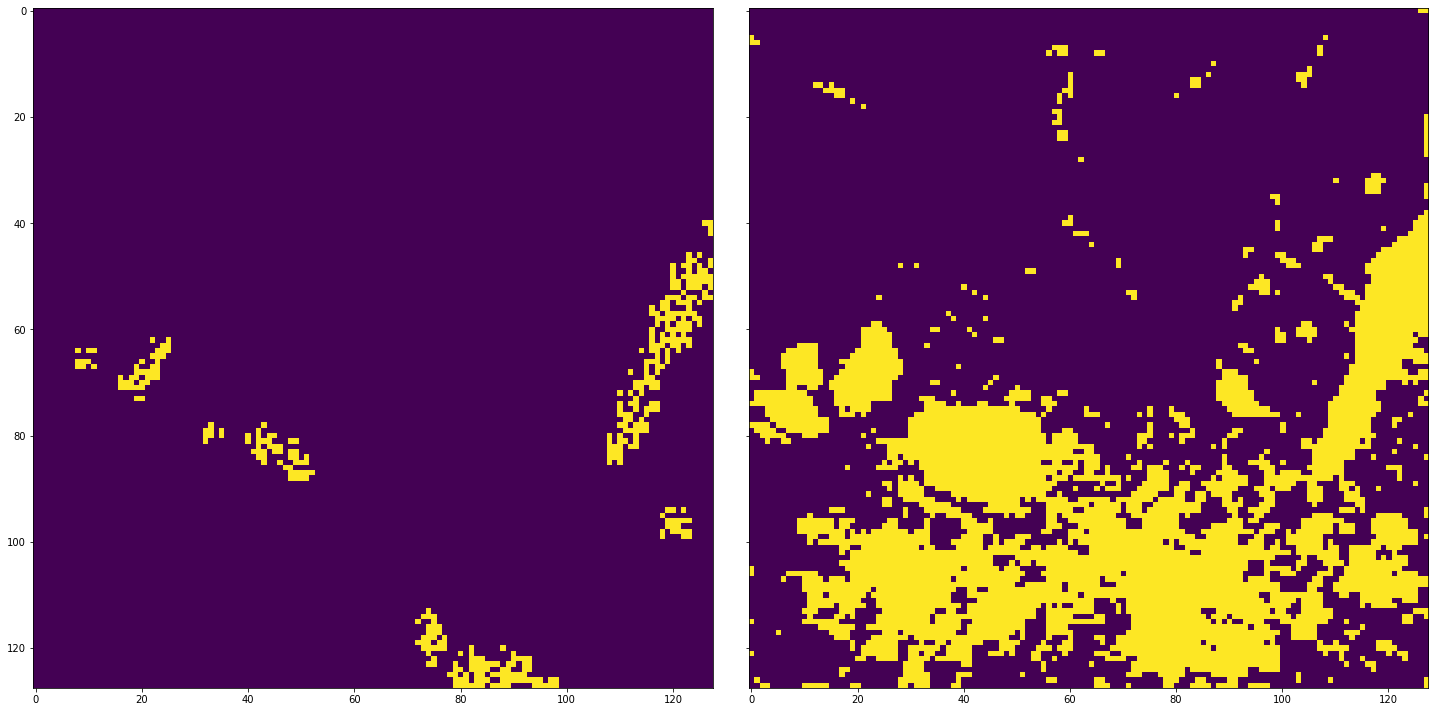

100%|██████████| 43/43 [00:05<00:00,  8.17it/s, loss=1.01]


=> Saving checkpoint
Pixel Accuracy: 467382/770048 = 60.70%
Average Dice Score: 0.8700324892997742
Average Similarity: 0.4350162446498871
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


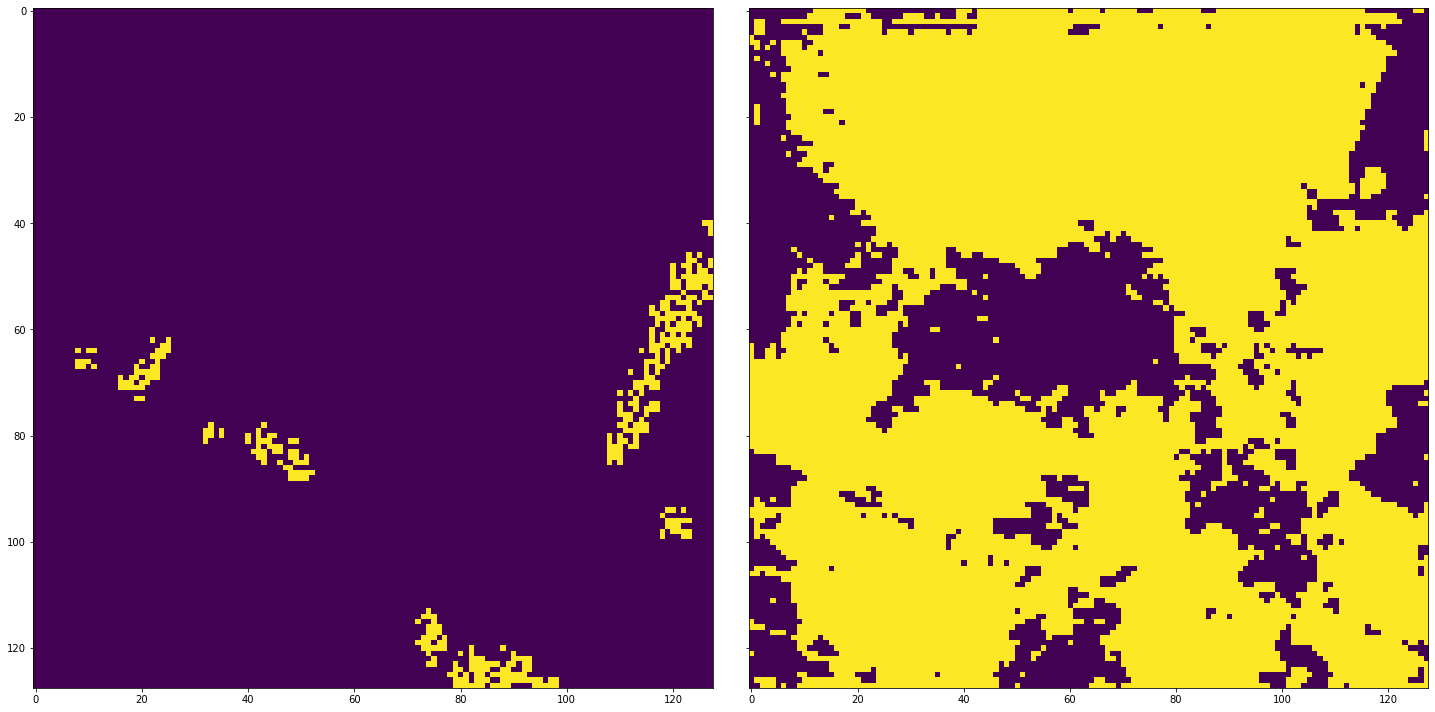

100%|██████████| 43/43 [00:05<00:00,  8.29it/s, loss=-5.96]


=> Saving checkpoint
Pixel Accuracy: 496495/770048 = 64.48%
Average Dice Score: 0.914834201335907
Average Similarity: 0.4574171006679535
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


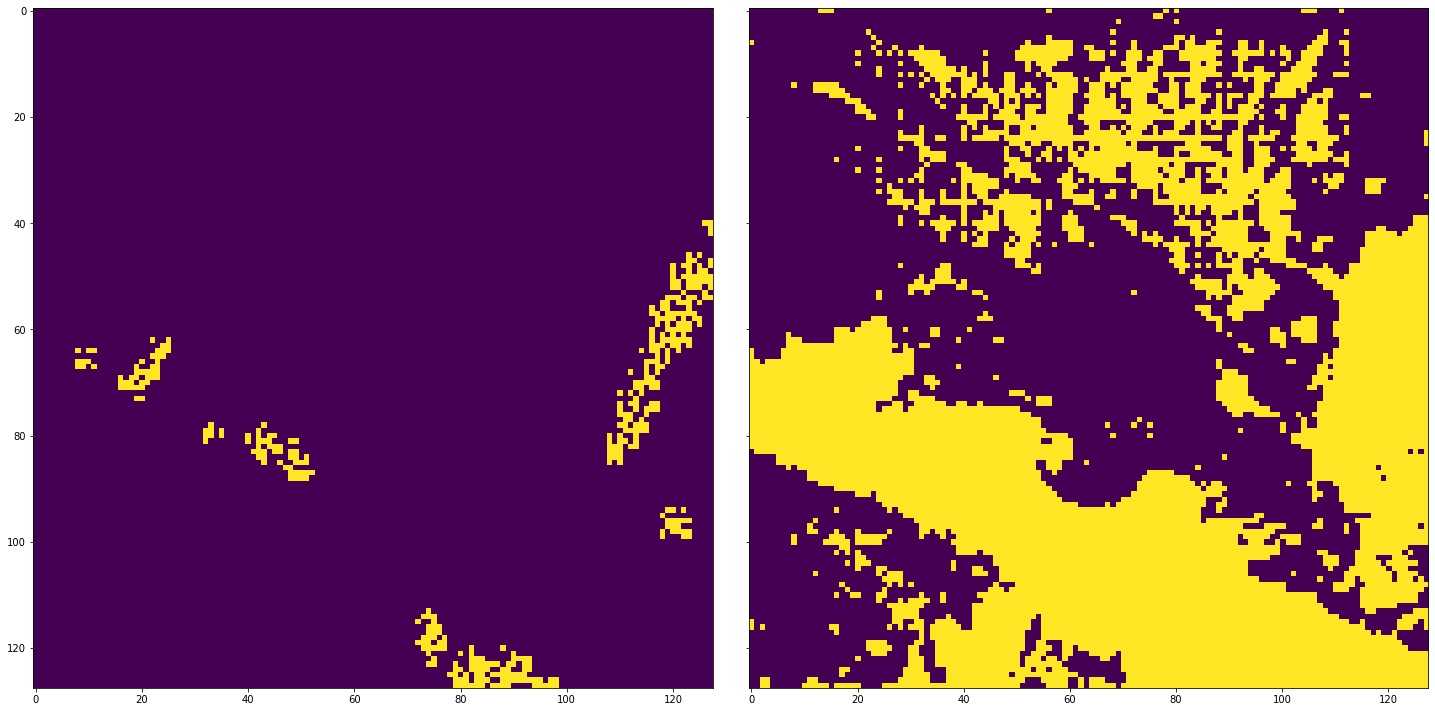

100%|██████████| 43/43 [00:05<00:00,  8.13it/s, loss=1.14]


=> Saving checkpoint
Pixel Accuracy: 515081/770048 = 66.89%
Average Dice Score: 0.9513121247291565
Average Similarity: 0.47565606236457825
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


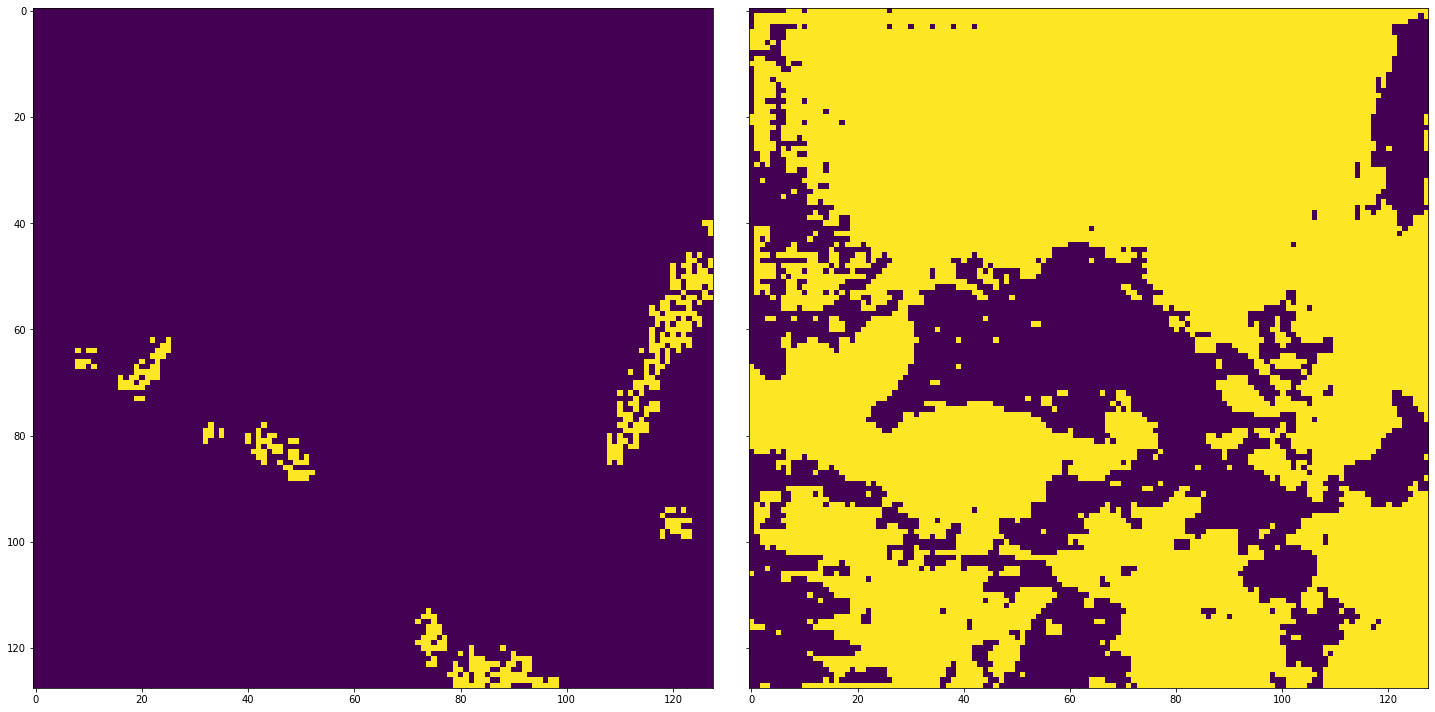

 16%|█▋        | 7/43 [00:00<00:04,  8.18it/s, loss=-7.59]

In [ ]:
# Now we'll do training here
# Hyperparameters
# LEARNING_RATE  = 1e-4
# DEVICE         = "cuda" if torch.cuda.is_available() else "cpu"
# BATCH_SIZE     = 32
# NUM_EPOCHS     = 100
# NUM_WORKERS    = 2
# IMAGE_HEIGHT   = 160
# IMAGE_WIDTH    = 240
# PIN_MEMORY     = True
# LOAD_MODEL     = False

# Dataset Paths
# TRAIN_IMG_DIR  = "data/train_images/"
# TRAIN_MASK_DIR = "data/train_masks/"
# VAL_IMG_DIR    = "data/val_images/"
# VAL_MASK_DIR   = "data/val_masks/"


# This whole function trains one epoch
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader) # tqdm gives us a progress bar

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE) #might not need to make it float since it might already be float? Also, unsqueeze is used cuz we're adding a channel

    # Forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # Backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Update tqdm loop
    loop.set_postfix(loss=loss.item())




def main():
  train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0 # This basically just divides by 255, so we get a value between 0 and 1
    ),
    ToTensorV2()
  ])

  val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0 # This basically just divides by 255, so we get a value between 0 and 1
    ),
    ToTensorV2()
  ])

  model = UNet(in_channels=3, out_channels=1).to(DEVICE) # if we wanted multiclass segmentation we'd change our channels and change our loss function to cross entropy loss
  loss_fn = nn.BCEWithLogitsLoss() # We're not doing sigmoid on the output of model which is why we're using this here
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  train_loader, val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_LBL_DIR,
      VAL_IMG_DIR,
      VAL_LBL_DIR,
      BATCH_SIZE,
      train_transform,
      val_transforms,
      NUM_WORKERS,
      PIN_MEMORY
  )

  if LOAD_MODEL:
    load_checkpoint(torch.load(CHECKPOINT), model)
  check_accuracy(val_loader, model, device=DEVICE)
  scaler = torch.cuda.amp.GradScaler()
  
  for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # Save Model
    checkpoint = {"state_dict":model.state_dict(), "optimizer":optimizer.state_dict()}
    save_checkpoint(checkpoint)

    # Check Accuracy
    check_accuracy(val_loader, model, device=DEVICE) # We get a high accuracy even though it's very inaccurate because the accuracy check is including the non-tent pixels, which is wrong

    # Save Predictions
    save_predictions_as_imgs(val_loader, model, folder=PREDICT_DIR, device=DEVICE)
    


    # TODO: need to associate predictions with actual image data. However, the filenames do not match up, so we need to figure out how to make those match up



    

    # Display
    if DISP_RESULTS:
      p_lbls = np.array([np.asarray(Image.open(path).convert('L'), dtype=np.float32) for path in sorted(glob(f"{PREDICT_DIR}/pred_*.{IMG_FORMAT}"))][:DISP_LIMIT])
      a_lbls = np.array([np.asarray(Image.open(path).convert('L'), dtype=np.float32) for path in sorted(glob(f"{PREDICT_DIR}/[!pred_]*.{IMG_FORMAT}"))][:p_lbls.shape[0]])
      # p_lbls = np.array([np.asarray(Image.open(path).convert('L'), dtype=np.float32) for path in sorted(glob(f"{PREDICT_DIR}/[!pred_]*.{IMG_FORMAT}"))][:DISP_LIMIT])
      # a_lbls = np.array([np.asarray(Image.open(path).convert('L'), dtype=np.float32) for path in sorted(glob(f"{TRAIN_LBL_DIR}/*.{IMG_FORMAT}"))][:p_lbls.shape[0]])

      print("label shape: (count, width, height, channels)")
      print("a_lbl shape: ", a_lbls.shape)
      print("p_lbl shape: ", p_lbls.shape)

      # If shapes aren't equal this won't work
      c_lbls = np.array([img for arr in np.stack((a_lbls, p_lbls), axis=1) for img in arr])

      print("c_lbl shape: ", c_lbls.shape)

      n = c_lbls.shape[0]//2

      fig = plt.figure(figsize=(c_lbls.shape[1]//DISP_SCALE, c_lbls.shape[2]//DISP_SCALE))
      grid = ImageGrid(fig, 111, nrows_ncols=(n, 2), axes_pad=0.5)

      for ax, im in zip(grid, c_lbls):
        ax.imshow(im)

      plt.show()
    else:
      print("Must set batch size to 1 to display")





# This solves issues when running on Windows (issues relating to NUM_WORKERS)
if __name__ == "__main__":
  main()